
# TP CNN
### Diane LINGRAND 

diane.lingrand@univ-cotedazur.fr   
Polytech - SI4 - 2021

## Introduction

In [ ]:
from IPython.display import Image
import tensorflow as tf
print(tf.__version__)
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation
import matplotlib.pyplot as plt


2.9.2


**The GPU**



To enable GPU backend in Google colab for your notebook:

1.   Runtime (top left corner) -> Change runtime type
2.   Put GPU as "Hardware accelerator"
3.   Save.

Or run the next cell:

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


## Convolutional Neural Networks (CNN)

Derived from the MLP, a convolutional neural network (CNN) is a type of artificial neural network that is specifically designed to process **pixel data**.  The layers of a CNN consist of an **input layer**, an **output layer** and **hidden layers** that can include **convolutional layers**, **pooling layers**, **fully connected layers** and **normalization layers**. It exists a lot of techniques to optimize CNN, like for example the dropout.

### Loading the dataset
In this part, we will use photographies of animals from the kaggle dataset [animals-10](https://www.kaggle.com/alessiocorrado99/animals10). Please connect to their site before loading the dataset from this [zip file](http://www.i3s.unice.fr/~lingrand/raw-img.zip). Decompress the zip file on your disk.

If you are using google colab, there is no need to download the dataset because I have a copy on my drive. You just need add to your drive this shared folder: https://drive.google.com/drive/folders/15cB1Ky-7OTUqfcQDZZyzc5HArt0GA6Sm?usp=sharing
You need to click on the link and click on "Add shortcut to Drive" and then select "My Drive".

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


To feed the data to a CNN, we need to shape it as required by Keras. As input, a 2D convolutional layer needs a **4D tensor** with shape: **(batch, rows, cols, channels)**. Therefore, we need to precise the "channels" axis, which can be seen as the number of level of color of each input: 3 channels in our case. We will fix the dimension of images according to the VGG-16 network: (224, 224).


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Flatten
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import glob
# when processing time is long, it's nice to see the progress bar
#!pip install tqdm
from tqdm import tqdm

### loading train data

Please read the code before running any of the cells!

In [81]:
#datasetRoot='/home/lingrand/Ens/MachineLearning/animals/raw-img/'
#datasetRoot='/whereYouPutTheImages/'
datasetRoot='/content/drive/My Drive/raw-img/'
# I suggest to reduce the number of classes for a first trial. 
# If you finish this notebook before the end of the course, you can add more classes (and images per class).
classes = ['mucca', 'elefante', 'gatto']
# , 'cavallo', 'scoiattolo', 'ragno', 'pecora', 'farfalla', 'gallina', 'cane']
nbClasses = len(classes)

#training data

rootTrain = datasetRoot+'train/'
classLabel = 0
reducedSizePerClass = 200 #in order to reduce the number of images per class
totalImg = nbClasses * reducedSizePerClass
xTrain = np.empty(shape=(totalImg,224,224,3))
yTrain = []
first = True
i= 0
for cl in classes:
    listImages = glob.glob(rootTrain+cl+'/*')
    yTrain += [classLabel]*reducedSizePerClass #len(listImages) # note that here ...
    for pathImg in tqdm(listImages[:reducedSizePerClass]): # and here, we have reduced the data to be loaded (only 1000 per class)
        img = image.load_img(pathImg, target_size=(224,224))
        im = image.img_to_array(img)
        im = np.expand_dims(im, axis=0)
        im = preprocess_input(im)
        xTrain[i,:,:,:] = im
        i += 1
    classLabel += 1
print(len(yTrain))
print(xTrain.shape)
yTrain = tensorflow.keras.utils.to_categorical(yTrain, nbClasses)


100%|██████████| 200/200 [00:02<00:00, 75.44it/s]

600
(600, 224, 224, 3)


**[TO DO - Students] What is the dimension of xTrain ? What do those dimensions represent ?**


The dimension of the xTrain is $(600, 224, 224, 3)$ where: \
- $600$ is the number of elements in the data set : $200$ imgs per $3$ classes
- $224, 244$ is the size of the images
- $3$ is the number of channels

**[TO DO - Students] Complete the following code to plot a few training images**


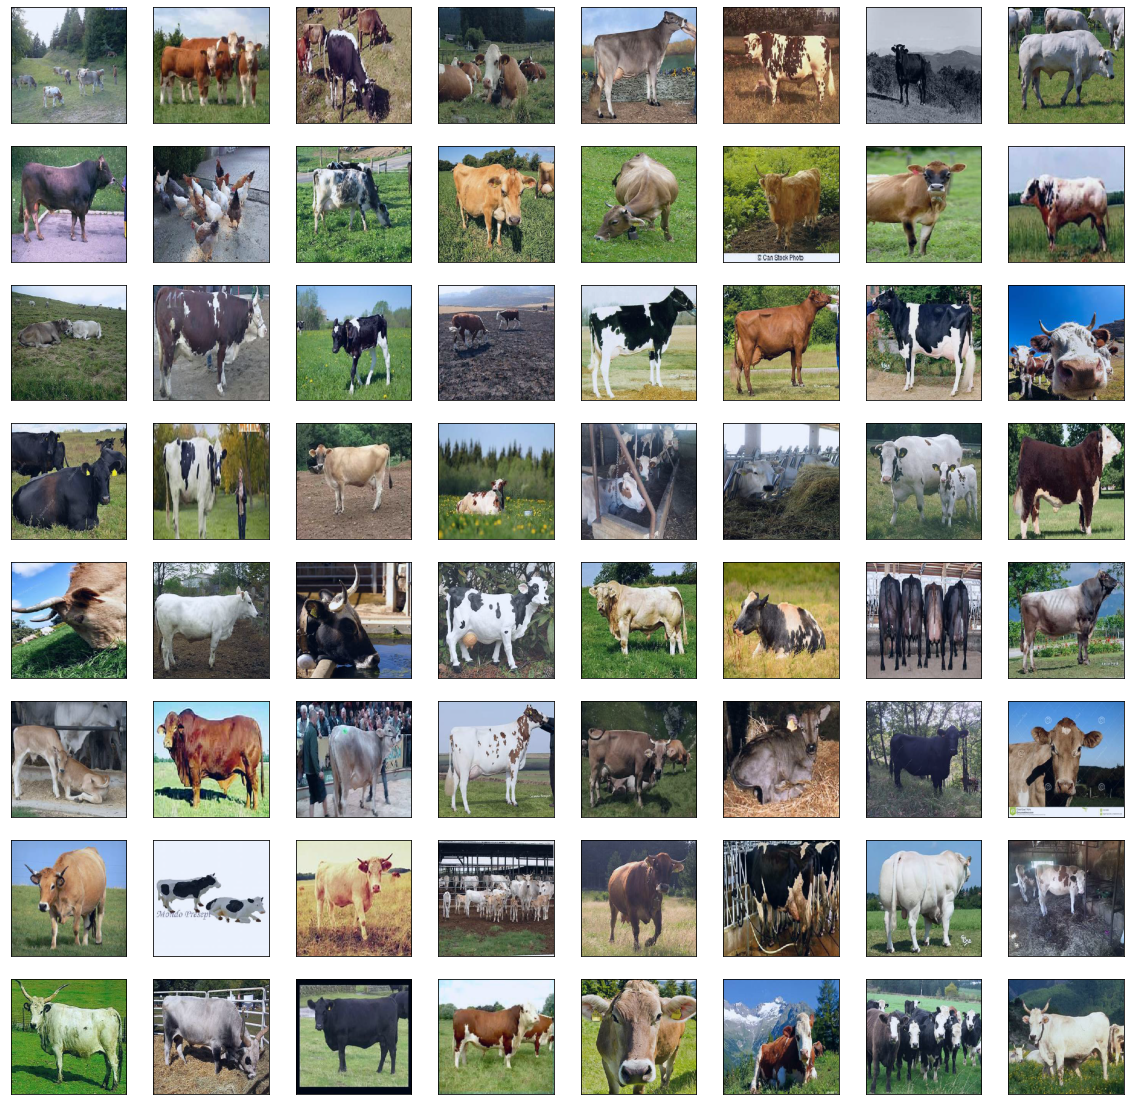

In [82]:
import matplotlib.pyplot as plt

square = 8
ix = 1
fig, axs = plt.subplots(square, square, figsize=(20, 20))
for i in range(square):
    for j in range(square):
        # specify subplot and turn of axis
        ax = axs[i,j]
        ax.set_xticks([])
        ax.set_yticks([])
        im = xTrain[ix][:,:,[2, 1, 0]]
        ax.imshow(((im - im.min()) / (im.max() - im.min())))
        ix += 1

In order to speed-up the time spent on this part of the lab, you may have noticed that we reduced the number of classes and the number of images per class. You can change these few lines of code if you want to work on the whole dataset.

### loading test data

In [83]:
#you need to use the same classes for the test dataset than for the train dataset
rootTest = datasetRoot+'test/'
classLabel = 0

totalTestImg = 0
for cl in classes:
    totalTestImg += len(glob.glob(rootTest+cl+'/*'))

print("There are ",totalTestImg, " images in test dataset.")
xTest = np.empty(shape=(totalTestImg,224,224,3))
yTest = []
i = 0

for cl in classes:
    listImages = glob.glob(rootTest+cl+'/*')
    yTest += [classLabel]*len(listImages)
    for pathImg in listImages:
        img = image.load_img(pathImg, target_size=(224, 224))
        im = image.img_to_array(img)
        im = np.expand_dims(im, axis=0)
        im = preprocess_input(im)
        xTest[i,:,:,:] = im 
    classLabel += 1
print(len(yTest))
print(xTest.shape)
yTest = tensorflow.keras.utils.to_categorical(yTest, nbClasses)

There are  991  images in test dataset.
991
(991, 224, 224, 3)


## Build your own CNN network

**[TO DO - Students] Start with the simplest CNN: 1 conv2D layer + 1 pooling + 1 dense layer. Fill the gaps and explain the parameters of the MaxPooling2D layer**

In [84]:
print(xTrain.shape)

(600, 224, 224, 3)


In [87]:
model = Sequential()
model.add(Conv2D(32,(3,3),padding='same',activation='relu', input_shape=(xTrain.shape[1:])))
model.add(MaxPooling2D(pool_size=(4, 4), strides=4, padding='same'))
model.add(Flatten())
model.add(Dense(nbClasses, activation="softmax"))
model.compile(optimizer='rmsprop',loss="categorical_crossentropy", metrics=['accuracy'])

Let's look at the dimension of all inputs and outputs:

In [88]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 100352)            0         
                                                                 
 dense_5 (Dense)             (None, 3)                 301059    
                                                                 
Total params: 301,955
Trainable params: 301,955
Non-trainable params: 0
_________________________________________________________________


**[TO DO - Students] Train and test this network.**

In [101]:
## Your code here
callbacks_list = [
  EarlyStopping(
    monitor='val_loss', 
    min_delta=0.0001, 
    patience=20, 
    verbose=0, 
    mode='auto', 
    restore_best_weights=True)
    ]

history = model.fit(
        xTrain,
        yTrain,
        validation_split=0.1,
        epochs=1000,
        batch_size=32,
        callbacks=callbacks_list,
        verbose=1
    )

Epoch 1/1000
17/17 [==============================] - 6s 336ms/step - loss: 5.2075 - accuracy: 0.3944 - val_loss: 3.5918 - val_accuracy: 0.2500
Epoch 2/1000
17/17 [==============================] - 4s 263ms/step - loss: 1.8256 - accuracy: 0.4074 - val_loss: 1.0393 - val_accuracy: 0.6167
Epoch 3/1000
17/17 [==============================] - 4s 241ms/step - loss: 1.4613 - accuracy: 0.4148 - val_loss: 0.4718 - val_accuracy: 0.8833
Epoch 4/1000
17/17 [==============================] - 4s 246ms/step - loss: 1.2364 - accuracy: 0.4370 - val_loss: 0.6462 - val_accuracy: 0.6500
Epoch 5/1000
17/17 [==============================] - 5s 272ms/step - loss: 1.2627 - accuracy: 0.4500 - val_loss: 2.1225 - val_accuracy: 0.0833
Epoch 6/1000
17/17 [==============================] - 5s 277ms/step - loss: 1.0807 - accuracy: 0.4889 - val_loss: 2.2969 - val_accuracy: 0.0167
Epoch 7/1000
17/17 [==============================] - 5s 284ms/step - loss: 1.1361 - accuracy: 0.4667 - val_loss: 1.4194 - val_accuracy:

**[TO DO - Students] Plot the training metrics (loss and accuracy). Test the model on the test data and compare the confusion matrix on the test data and train data**

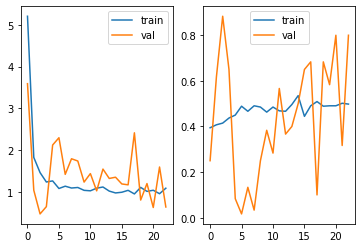

In [102]:
# Plot history
f, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='val')
ax1.legend()
ax2.plot(history.history['accuracy'], label='train')
ax2.plot(history.history['val_accuracy'], label='val')
ax2.legend()
plt.show()

In [103]:
# for you !
score = model.evaluate(xTest,yTest)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

ypred = np.argmax(model.predict(xTest), axis=1)
print("F1 score: ", f1_score(ypred,np.argmax(yTest,axis=1),average='micro'))

31/31 [==============================] - 6s 197ms/step - loss: 1.0993 - accuracy: 0.2926
accuracy: 29.26%
31/31 [==============================] - 4s 128ms/step
F1 score:  0.29263370332996974


Visualize the confusion matrix on the test dataset for this model

In [104]:
y_pred = model.predict(xTrain)


19/19 [==============================] - 3s 143ms/step


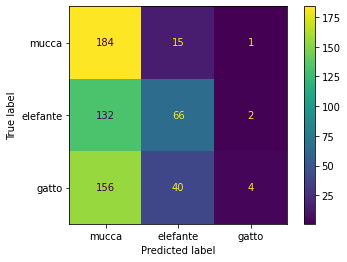

In [105]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(classes)

cm = confusion_matrix(le.inverse_transform(np.argmax(yTrain, axis=1)), 
                      le.inverse_transform(np.argmax(y_pred, axis=1)), 
                      labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot()

How is the accuracy or F1-measure on the test dataset?

Are you satisfied by the performances?

Try to modify the architecture (add layers) and some of the parameters.

### About Dropout 

*Study this part only if you have time for it. It concerns the previous network but prefer to study first part II and come back here after.*

Simply put, dropout refers to ignoring units (i.e. neurons) during the training phase of certain set of neurons which is chosen at random. By “ignoring”, I mean these units are not considered during a particular forward or backward pass.

Why use dropout ? A fully connected layer occupies most of the parameters, and hence, neurons develop co-dependency amongst each other during training which curbs the individual power of each neuron leading to overfitting of training data.

**Let's add dropout and activation functions to the network!**

In [108]:
from tensorflow.keras.layers import Dropout

model = Sequential(name='MLP model with dropout') 

model = Sequential()
model.add(Conv2D(256,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(GlobalAveragePooling2D())
model.add(Dense(200,activation='relu'))
# adding dropout to the previous layer
model.add(Dropout(0.2))

model.add(Dense(nbClasses, activation='softmax'))

model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 222, 222, 256)     7168      
                                                                 
 global_average_pooling2d_5   (None, 256)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 200)               51400     
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_17 (Dense)            (None, 3)                 603       
                                                                 
Total params: 59,171
Trainable params: 59,171
Non-trainable params: 0
_________________________________________________

**[TO DO - Students] Plot the training metrics (loss and accuracy). Test the model on the test data and compare the confusion matrix on the test data and train data**

In [110]:
history = model.fit(
        xTrain,
        yTrain,
        validation_split=0.1,
        epochs=1000,
        batch_size=264,
        callbacks=callbacks_list,
        verbose=1
    )

Epoch 1/1000


ResourceExhaustedError: ignored

In [ ]:
# Plot history
f, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='val')
ax1.legend()
ax2.plot(history.history['accuracy'], label='train')
ax2.plot(history.history['val_accuracy'], label='val')
ax2.legend()
plt.show()

## Using a pre-learned network

### loading VGG-16 description part and adding layers to build our own classification network

In [143]:
VGGmodel = VGG16(weights='imagenet', include_top=False)
#features = VGGmodel.predict(xTrain)
#print(features.shape)
VGGmodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**[TO DO - Students] What is the goal of the include_top=false parameter and adapt the model to our classification model by filling the gaps of the following cell**

In [144]:
# we will add layers to this feature extraction part of VGG network
m = VGGmodel.output
# we start with a global average pooling
m = GlobalAveragePooling2D()(m)
# and add a fully-connected layer
m = Dense(1024, activation='relu')(m)
# finally, the softmax layer for predictions (we have nbClasses classes)
predictions = Dense(nbClasses, activation="softmax")(m)

# global network
model = Model(inputs=VGGmodel.input, outputs=predictions)

Can you display the architecture of this entire network?

In [145]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

**[TO DO - Students] What would happen if we ran model.fit now ? Make it so that the training will only train the new layers and train the model.**

In [146]:
for l in model.layers[:-3]:
  l.trainable = False
  

In [147]:
## Your code here
callbacks_list = [
  EarlyStopping(
    monitor='val_loss', 
    min_delta=0.0001, 
    patience=20, 
    verbose=0, 
    mode='auto', 
    restore_best_weights=True)
    ]
model.compile(optimizer='rmsprop',loss="categorical_crossentropy", metrics=['accuracy'])

In [148]:
history = model.fit(
        xTrain,
        yTrain,
        validation_split=0.1,
        epochs=1000,
        batch_size=128,
        callbacks=callbacks_list,
        verbose=1,
        shuffle=True
    )

Epoch 1/1000
5/5 [==============================] - 4s 689ms/step - loss: 11.6965 - accuracy: 0.5963 - val_loss: 0.3504 - val_accuracy: 0.9500
Epoch 2/1000
5/5 [==============================] - 4s 867ms/step - loss: 0.1098 - accuracy: 0.9815 - val_loss: 0.0433 - val_accuracy: 0.9667
Epoch 3/1000
5/5 [==============================] - 4s 821ms/step - loss: 0.0599 - accuracy: 0.9852 - val_loss: 0.0362 - val_accuracy: 0.9833
Epoch 4/1000
5/5 [==============================] - 4s 748ms/step - loss: 0.0142 - accuracy: 0.9944 - val_loss: 0.1008 - val_accuracy: 0.9667
Epoch 5/1000
5/5 [==============================] - 4s 961ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0819 - val_accuracy: 0.9667
Epoch 6/1000
5/5 [==============================] - 3s 602ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0598 - val_accuracy: 0.9667
Epoch 7/1000
5/5 [==============================] - 4s 948ms/step - loss: 8.1672e-04 - accuracy: 1.0000 - val_loss: 0.1173 - val_accuracy: 0.9667
E

19/19 [==============================] - 3s 157ms/step


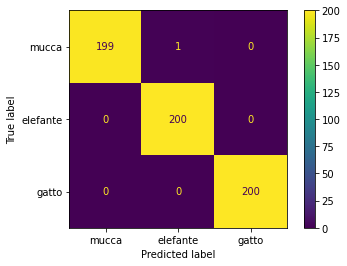

In [149]:
y_pred = model.predict(xTrain)

le = LabelEncoder()
le.fit(classes)

cm = confusion_matrix(le.inverse_transform(np.argmax(yTrain, axis=1)), 
                      le.inverse_transform(np.argmax(y_pred, axis=1)), 
                      labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot()

Some classes are not predicted because we did not shuffle the data and every samples of some datasets are part of the validation set.

### fine-tune the network

Fine-tune the entire network if you have enough computing ressouces, otherwise, carefully choose the layers you want to fine-tune.

In [150]:
for i, layer in enumerate(VGGmodel.layers):
   print(i, layer.name)
model.summary()

0 input_5
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, Non

In this example, we will fine-tune the last convolution block starting at layer number 15 (block5_conv).

In [151]:
from tensorflow.keras.optimizers import RMSprop
callbacks_list = [
  EarlyStopping(
    monitor='val_loss', 
    min_delta=0.0001, 
    patience=20, 
    verbose=0, 
    mode='auto', 
    restore_best_weights=True)
    ]

for layer in model.layers[:11]:
   layer.trainable = False
for layer in model.layers[11:]:
   layer.trainable = True
#need to recompile the network
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])
#and train again ...
model.fit(xTrain, yTrain, epochs=20, batch_size=128, validation_split=0.2, callbacks=[callbacks_list],verbose=1)

Epoch 1/20
4/4 [==============================] - 26s 8s/step - loss: 40.7752 - accuracy: 0.5583 - val_loss: 1.1090 - val_accuracy: 0.1667
Epoch 2/20
4/4 [==============================] - 5s 1s/step - loss: 0.9642 - accuracy: 0.5542 - val_loss: 0.7115 - val_accuracy: 0.8500
Epoch 3/20
4/4 [==============================] - 5s 1s/step - loss: 0.8689 - accuracy: 0.6062 - val_loss: 1.6091 - val_accuracy: 0.0500
Epoch 4/20
4/4 [==============================] - 5s 1s/step - loss: 0.7826 - accuracy: 0.6292 - val_loss: 0.7302 - val_accuracy: 0.7750
Epoch 5/20
4/4 [==============================] - 5s 1s/step - loss: 0.6489 - accuracy: 0.6958 - val_loss: 0.1985 - val_accuracy: 0.9667
Epoch 6/20
4/4 [==============================] - 4s 1s/step - loss: 0.5961 - accuracy: 0.7417 - val_loss: 0.6716 - val_accuracy: 0.7333
Epoch 7/20
4/4 [==============================] - 5s 1s/step - loss: 0.6812 - accuracy: 0.7208 - val_loss: 1.0723 - val_accuracy: 0.6250
Epoch 8/20
4/4 [=======================

You already know how to evaluate the performances on the test dataset and display the confusion matrix. You can also modify the code that loads the test dataset in order to reduce it's size. Let's do it!

19/19 [==============================] - 5s 268ms/step


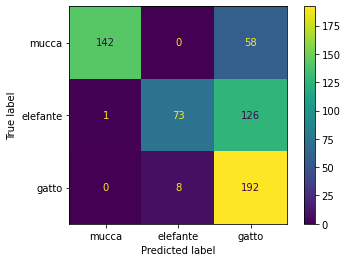

In [152]:
#enter here your code for evaluation of performances
y_pred = model.predict(xTrain)

le = LabelEncoder()
le.fit(classes)

cm = confusion_matrix(le.inverse_transform(np.argmax(yTrain, axis=1)), 
                      le.inverse_transform(np.argmax(y_pred, axis=1)), 
                      labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot()

You are now free to experiments changes in the network:
* add a dense layer
* modify the number of neurons in dense layer(s)
* change the global average polling
* add classes and data
* experiment other optimizers (SGD, Adam, ...)


...

## Visualizing the convolution filters

In this part, we'll visualize the convolution filters and their effect on the input for our previously trained model

**[TO DO - Students] What is the following code plotting ?**

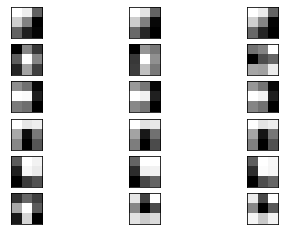

In [156]:
layer_id = 1
# retrieve weights from the second hidden layer
filters, biases = model.layers[layer_id].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

Plot the filters for the first layers

**[TO DO - Students] Now, let's visualize the feature maps of various depths. Fill the gaps to do so.**

In [ ]:
# redefine model to output right after the first hidden layer
img = xTrain[...].reshape(...)

for layer in ['block1_conv2', 'block2_conv2', 'block3_conv1', 'block4_conv1', 'block5_conv1']:
    model_fm = Model(inputs=model.inputs, outputs=...)
    feature_maps = model_fm.predict(img)
    # plot all 64 maps in an 8x8 squares
    square = 6
    ix = 1
    fig, axs = plt.subplots(square, square, figsize=(10, 10))
    for i in range(square):
      for j in range(square):
        # specify subplot and turn of axis
        ax = axs[i,j]
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        ax.imshow(feature_maps[0, :, :, ...], cmap='gray')
        ix += 1
    # show the figure
    fig.suptitle(layer, fontsize=20)
    plt.show()


## Activation maximization

Another solution to interpret the inner mecanisms of the network is to use Activation Maximization. This method computes the optimal output which gives the maximum value of a particular activation. Used on the classification layers, this can give us an idea of the patterns recognized to classify a particular class.

To do that we'll use the tf_keras_vis module.

In [157]:
[i for i in range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [158]:
! pip install tf_keras_vis
from tf_keras_vis.activation_maximization import ActivationMaximization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 793 kB/s 


In [159]:
def loss(output):
  return (output[0][0], output[1][1], output[2][2])

def model_modifier(m):
    m.layers[-1].activation = tensorflow.keras.activations.linear

visualize_activation = ActivationMaximization(model, model_modifier)

In [ ]:
seed_input = tensorflow.random.uniform((3, 224, 224, 3), 0, 255)
activations = visualize_activation(loss, seed_input=seed_input, steps=512)
images = [activation.astype(np.float32) for activation in activations]

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
for i in range(0, len(images)):
  ax = axs[i]
  visualization = images[i].reshape(224,224,3)
  visualization = (visualization - visualization.min())/(visualization.max()-visualization.min())
  visualization = visualization[:,:,[2,1,0]]
  ax.imshow(visualization)
